In [3]:
!pip install pyspark

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#raw_data = spark.read.format("csv").option("header","true").option("inferSchema", "true").load(r".\\diabetes.csv")
dataset = spark.read.csv('/content/drive/MyDrive/ML CN7030 /titanic_synthetic_data.csv',inferSchema=True, header =True)

In [7]:
# what are the columns in this dataset
dataset.columns

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Sex',
 'Survived',
 'Embarked_Q',
 'Embarked_S']

In [8]:
dataset.describe().select("Summary","Age","Sibsp","Fare","Sex").show()

+-------+------------------+------------------+------------------+------------------+
|Summary|               Age|             Sibsp|              Fare|               Sex|
+-------+------------------+------------------+------------------+------------------+
|  count|           1000000|           1000000|           1000000|           1000000|
|   mean|         39.517847|          4.500906| 254.9829083944402|           0.50082|
| stddev|23.092708389398037|2.8714427426552285|141.53963219142216|0.4999995775993916|
|    min|                 0|                 0|10.000191449724019|                 0|
|    max|                79|                 9| 499.9999338139367|                 1|
+-------+------------------+------------------+------------------+------------------+



In [9]:
dataset.describe().select("Parch","Embarked_S","Embarked_Q").show()

+------------------+------------------+-------------------+
|             Parch|        Embarked_S|         Embarked_Q|
+------------------+------------------+-------------------+
|           1000000|           1000000|            1000000|
|          4.497493|          0.333661|           0.332717|
|2.8728101169393594|0.4715204761307361|0.47118639616145436|
|                 0|                 0|                  0|
|                 9|                 1|                  1|
+------------------+------------------+-------------------+



In [10]:
dataset.describe().select("Pclass").show()

+------------------+
|            Pclass|
+------------------+
|           1000000|
|          1.999411|
|0.8168263709530482|
|                 1|
|                 3|
+------------------+



In [11]:
from pyspark.sql.functions import col,isnan, when, count
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]
   ).show()

+------+---+-----+-----+----+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+----+---+--------+----------+----------+
|     0|  0|    0|    0|   0|  0|       0|         0|         0|
+------+---+-----+-----+----+---+--------+----------+----------+



In [12]:
# replace min value of zeros with None as data cleaning processs
import numpy as np
from pyspark.sql.functions import when
dataset=dataset.withColumn("SibSp",when(dataset.SibSp==0, None).otherwise (dataset.SibSp)) # Corrected typo
dataset=dataset.withColumn("Fare",when(dataset.Fare==0,None).otherwise(dataset.Fare))
dataset=dataset.withColumn("Age",when(dataset.Age==0,None).otherwise(dataset.Age))
dataset=dataset.withColumn("Parch",when(dataset.Parch==0,None).otherwise(dataset.Parch))
dataset=dataset.withColumn("Pclass",when(dataset.Pclass==0,None).otherwise(dataset.Pclass))
dataset.select("Pclass","Parch","Age","Fare","SibSp").show(5)

+------+-----+---+------------------+-----+
|Pclass|Parch|Age|              Fare|SibSp|
+------+-----+---+------------------+-----+
|     3|    7| 42|397.00178367782024|    6|
|     1|    7| 52|302.12770032784186|    6|
|     3|    8| 25| 427.1058765283985|    3|
|     3|    7| 32| 326.8049924602327|    9|
|     1|    5| 40|17.718838497771657| NULL|
+------+-----+---+------------------+-----+
only showing top 5 rows



In [13]:
# check again NAN values
from pyspark.sql.functions import col,isnan, when, count
dataset.select([count(when(isnan(c) , c)).alias(c) for c in dataset.columns]
   ).show()

+------+---+-----+-----+----+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+----+---+--------+----------+----------+
|     0|  0|    0|    0|   0|  0|       0|         0|         0|
+------+---+-----+-----+----+---+--------+----------+----------+



In [14]:
#impute
from pyspark.ml.feature import Imputer
imputer=Imputer(inputCols=["SibSp","Fare","Age","Parch"],outputCols=["SibSp","Fare","Age","Parch"])
model=imputer.fit(dataset)
dataset=model.transform(dataset)
dataset.show(5)

+------+---+-----+-----+------------------+---+--------+----------+----------+
|Pclass|Age|SibSp|Parch|              Fare|Sex|Survived|Embarked_Q|Embarked_S|
+------+---+-----+-----+------------------+---+--------+----------+----------+
|     3| 42|    6|    7|397.00178367782024|  0|       0|         0|         1|
|     1| 52|    6|    7|302.12770032784186|  0|       0|         1|         0|
|     3| 25|    3|    8| 427.1058765283985|  1|       1|         1|         0|
|     3| 32|    9|    7| 326.8049924602327|  1|       0|         0|         0|
|     1| 40|    4|    5|17.718838497771657|  0|       0|         0|         0|
+------+---+-----+-----+------------------+---+--------+----------+----------+
only showing top 5 rows



In [15]:
#us combine all the features in one single feature vector.
cols=dataset.columns
cols.remove("Survived")
cols.remove("Fare")
# Let us import the vector assembler
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
# Now let us use the transform method to transform our dataset
dataset=assembler.transform(dataset)
dataset.select("features").show(truncate=False)


+------------------------------+
|features                      |
+------------------------------+
|[3.0,42.0,6.0,7.0,0.0,0.0,1.0]|
|[1.0,52.0,6.0,7.0,0.0,1.0,0.0]|
|[3.0,25.0,3.0,8.0,1.0,1.0,0.0]|
|[3.0,32.0,9.0,7.0,1.0,0.0,0.0]|
|[1.0,40.0,4.0,5.0,0.0,0.0,0.0]|
|[1.0,20.0,7.0,2.0,0.0,0.0,0.0]|
|[3.0,76.0,4.0,9.0,0.0,1.0,0.0]|
|[2.0,22.0,4.0,7.0,1.0,0.0,0.0]|
|[3.0,78.0,4.0,8.0,1.0,0.0,0.0]|
|[3.0,15.0,1.0,8.0,1.0,1.0,0.0]|
|[3.0,68.0,8.0,7.0,1.0,0.0,1.0]|
|[3.0,3.0,7.0,1.0,0.0,1.0,0.0] |
|[1.0,63.0,4.0,4.0,1.0,0.0,0.0]|
|[3.0,40.0,9.0,8.0,0.0,0.0,1.0]|
|[2.0,62.0,3.0,4.0,1.0,0.0,0.0]|
|[1.0,41.0,2.0,8.0,1.0,0.0,1.0]|
|[2.0,40.0,4.0,2.0,1.0,0.0,1.0]|
|[2.0,64.0,4.0,4.0,0.0,0.0,1.0]|
|[2.0,67.0,3.0,6.0,0.0,0.0,0.0]|
|[2.0,35.0,4.0,1.0,1.0,0.0,0.0]|
+------------------------------+
only showing top 20 rows



In [16]:
#Standard Sclarizer
from pyspark.ml.feature import StandardScaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
dataset=standardscaler.fit(dataset).transform(dataset)
dataset.select("features","Scaled_features").show(5)


+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[3.0,42.0,6.0,7.0...|[3.67275115824148...|
|[1.0,52.0,6.0,7.0...|[1.22425038608049...|
|[3.0,25.0,3.0,8.0...|[3.67275115824148...|
|[3.0,32.0,9.0,7.0...|[3.67275115824148...|
|[1.0,40.0,4.0,5.0...|[1.22425038608049...|
+--------------------+--------------------+
only showing top 5 rows



In [17]:
dataset.show(5,truncate=False)

+------+---+-----+-----+------------------+---+--------+----------+----------+------------------------------+----------------------------------------------------------------------------------------------------------------------+
|Pclass|Age|SibSp|Parch|Fare              |Sex|Survived|Embarked_Q|Embarked_S|features                      |Scaled_features                                                                                                       |
+------+---+-----+-----+------------------+---+--------+----------+----------+------------------------------+----------------------------------------------------------------------------------------------------------------------+
|3     |42 |6    |7    |397.00178367782024|0  |0       |0         |1         |[3.0,42.0,6.0,7.0,0.0,0.0,1.0]|[3.672751158241489,1.853360446789893,2.431076881147427,2.835650216431042,0.0,0.0,2.120798672850694]                   |
|1     |52 |6    |7    |302.12770032784186|0  |0       |1         |0         |[1.0,5

In [18]:
#Train, test split
train, test = dataset.randomSplit([0.8, 0.2], seed=12345)

In [19]:
#imbalance in the dataset, observe the use of Where
dataset_size=float(train.select("Survived").count())
numPositives=train.select("Survived").where('Survived == 1').count()
per_ones=(float(numPositives)/float(dataset_size))*100
numNegatives=float(dataset_size-numPositives)
print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 400075
Percentage of ones are 49.99412679132865


In [20]:
BalancingRatio= numNegatives/dataset_size
print('BalancingRatio = {}'.format(BalancingRatio))

BalancingRatio = 0.5000587320867136


In [21]:
# balance
train=train.withColumn("classWeights", when(train.Survived == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.5000587320867136|
|0.4999412679132864|
|0.5000587320867136|
|0.5000587320867136|
|0.5000587320867136|
+------------------+
only showing top 5 rows



In [22]:
#Feature selection
# Feature selection using chisquareSelector
from pyspark.ml.feature import ChiSqSelector
css = ChiSqSelector(featuresCol='Scaled_features',outputCol='Aspect',labelCol='Survived',fpr=0.05)
train=css.fit(train).transform(train)
test=css.fit(test).transform(test)
test.select("Aspect").show(5,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------+
|Aspect                                                                                                                     |
+---------------------------------------------------------------------------------------------------------------------------+
|[1.2242503860804963,0.044127629685473645,0.40517948019123784,0.40509288806157745,0.0,0.0,0.0]                              |
|[1.2242503860804963,0.044127629685473645,0.40517948019123784,0.40509288806157745,2.0000016896038306,2.1223023587831746,0.0]|
|[1.2242503860804963,0.044127629685473645,0.40517948019123784,0.40509288806157745,0.0,0.0,2.120798672850694]                |
|[1.2242503860804963,0.044127629685473645,0.40517948019123784,0.8101857761231549,0.0,0.0,0.0]                               |
|[1.2242503860804963,0.044127629685473645,0.40517948019123784,0.8101857761231549,0.0,0.0,2.120798672850694]           

In [23]:
train.show()

+------+---+-----+-----+------------------+---+--------+----------+----------+--------------------+--------------------+------------------+--------------------+
|Pclass|Age|SibSp|Parch|              Fare|Sex|Survived|Embarked_Q|Embarked_S|            features|     Scaled_features|      classWeights|              Aspect|
+------+---+-----+-----+------------------+---+--------+----------+----------+--------------------+--------------------+------------------+--------------------+
|     1|  1|    1|    1|28.811477212867022|  0|       1|         0|         0|[1.0,1.0,1.0,1.0,...|[1.22425038608049...|0.5000587320867136|[1.22425038608049...|
|     1|  1|    1|    1| 37.35074336825958|  1|       0|         0|         1|[1.0,1.0,1.0,1.0,...|[1.22425038608049...|0.4999412679132864|[1.22425038608049...|
|     1|  1|    1|    1| 98.03437973491282|  1|       1|         0|         0|[1.0,1.0,1.0,1.0,...|[1.22425038608049...|0.5000587320867136|[1.22425038608049...|
|     1|  1|    1|    1|121.115055

In [24]:
train.select("Parch").distinct().show()


+-----+
|Parch|
+-----+
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|    2|
+-----+



In [25]:
#Building a classification model using Logistic Regression (LR)
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="Survived", featuresCol="Aspect",weightCol="classWeights",maxIter=10)
model=lr.fit(train)
predict_train=model.transform(train)
predict_test=model.transform(test)
predict_test.select("Survived","prediction").show(10)

+--------+----------+
|Survived|prediction|
+--------+----------+
|       1|       1.0|
|       1|       0.0|
|       0|       1.0|
|       1|       1.0|
|       1|       1.0|
|       1|       0.0|
|       0|       0.0|
|       1|       0.0|
|       1|       1.0|
|       0|       0.0|
+--------+----------+
only showing top 10 rows



In [26]:
#Evaluating the model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol="Survived")
# We have only two choices: area under ROC and PR curves :-(
auroc = evaluator.evaluate(predict_test, {evaluator.metricName: "areaUnderROC"})

print("Area under ROC Curve: {:.4f}".format(auroc))

predict_test.select("Survived","prediction","probability").show(15)

Area under ROC Curve: 0.5010
+--------+----------+--------------------+
|Survived|prediction|         probability|
+--------+----------+--------------------+
|       1|       1.0|[0.49930380741710...|
|       1|       0.0|[0.50041715947243...|
|       0|       1.0|[0.49941555622916...|
|       1|       1.0|[0.49924458660988...|
|       1|       1.0|[0.49935633538648...|
|       1|       0.0|[0.50035793857601...|
|       0|       0.0|[0.50032318520758...|
|       1|       0.0|[0.50032318520758...|
|       1|       1.0|[0.49910167759004...|
|       0|       0.0|[0.50026396429599...|
|       1|       1.0|[0.49910167759004...|
|       1|       1.0|[0.49910167759004...|
|       0|       1.0|[0.49912614506070...|
|       1|       1.0|[0.49912614506070...|
|       1|       0.0|[0.50023949675469...|
+--------+----------+--------------------+
only showing top 15 rows



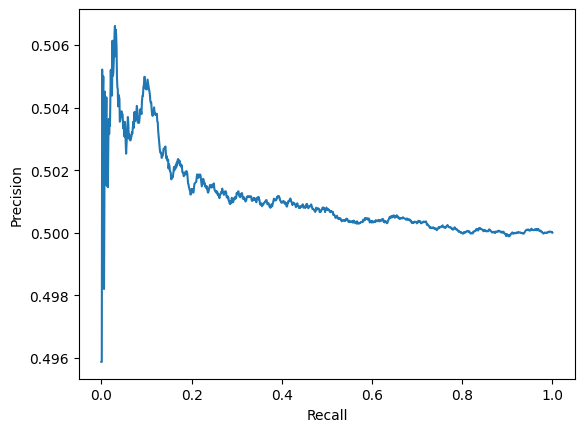

Model Accuracy 0.5007594774991688
FP rate [0.5017159282634587, 0.49676511673819335]
TR rate [0.5032348832618067, 0.4982840717365413]


In [27]:
print(model.summary)
import matplotlib.pyplot as plt
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
print("Model Accuracy",model.summary.accuracy)
print("FP rate",model.summary.falsePositiveRateByLabel)
print("TR rate",model.summary.truePositiveRateByLabel)

In [28]:
#print("Total True Positive i.e. diabetes",predict_test.select("Outcome").where('Outcome == 1.0').count())
#print("Total True  Negative,i.e. without diabetes",predict_test.select("Outcome").where('Outcome == 0.0').count())
pr = predict_test.toPandas()
TruePositive =0
FalsePositive=0
TrueNegative=0
FalseNegative=0
Postive=1.0
Negative=0.0
pos=0
Neg=0

print("Total",len(pr["Survived"]))
for lbl in range(len(pr["Survived"])):
  if  pr["prediction"][lbl]==Postive:
    pos+=1
    if pr["prediction"][lbl]==pr["Survived"][lbl]:
      TruePositive+=1
    else:
      FalsePositive+=1
  if  pr["prediction"][lbl]==Negative:
    Neg+=1
    if pr["prediction"][lbl]==pr["Survived"][lbl]:
      TrueNegative+=1
    else:
      FalseNegative+=1
#print("Total Positive & Negative predicted,  Survived: ",pos,",Non Survided",Neg)
print("TruePostive",TruePositive,"FalsePostive",FalsePositive)
print("TrueNegative",TrueNegative,"FalseNegative",FalseNegative)

Total 199756
TruePostive 49826 FalsePostive 49704
TrueNegative 50257 FalseNegative 49969


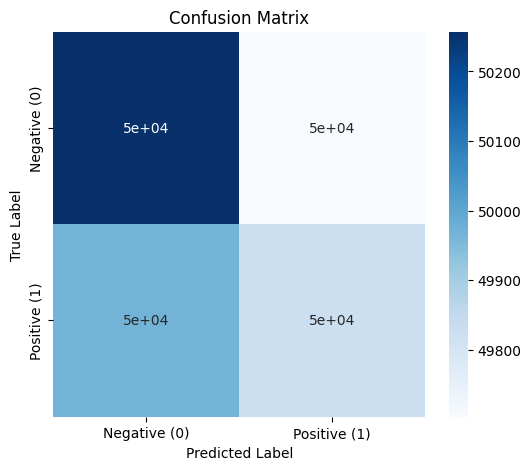

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

TN = TrueNegative
FP = FalsePositive
FN = FalseNegative
TP = TruePositive
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])
labels = ["Negative (0)", "Positive (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True,  cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()